# Creating OLS Diagnostic plots in Python

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import scipy.stats as stats
from pydataset import data

import OLSplots

In [2]:
mtcars = data('mtcars')
mtcars.head()

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


## Conducting the regression

In [3]:
model = smf.ols(formula='mpg ~ cyl + wt', data=mtcars)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     70.91
Date:                Tue, 19 Nov 2019   Prob (F-statistic):           6.81e-12
Time:                        21:19:48   Log-Likelihood:                -74.005
No. Observations:                  32   AIC:                             154.0
Df Residuals:                      29   BIC:                             158.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.6863      1.715     23.141      0.0

# Making the plots in an R OLS
1. Residuals vs. Fitted
2. Normal QQ plot
3. Scale - Location Plot
4. Residuals vs. Leverage

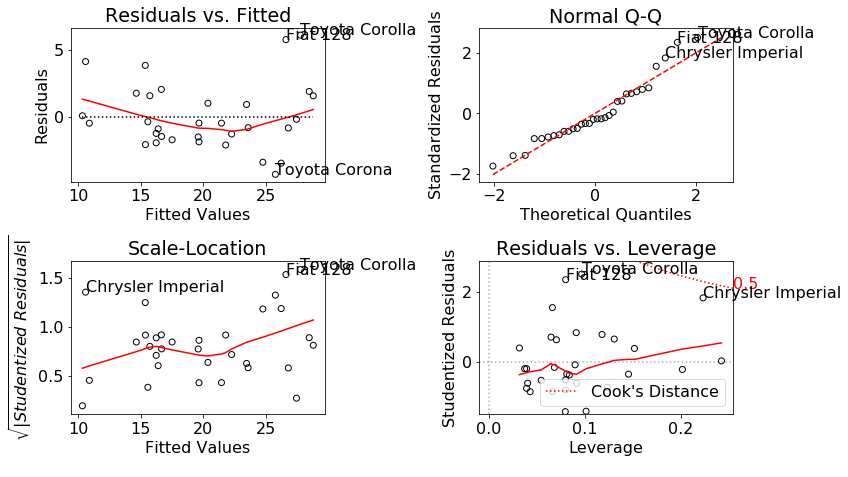

In [42]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (12,7)
OLSplots.allplots(results)
plt.show()

## 1. Residuals vs. Fitted

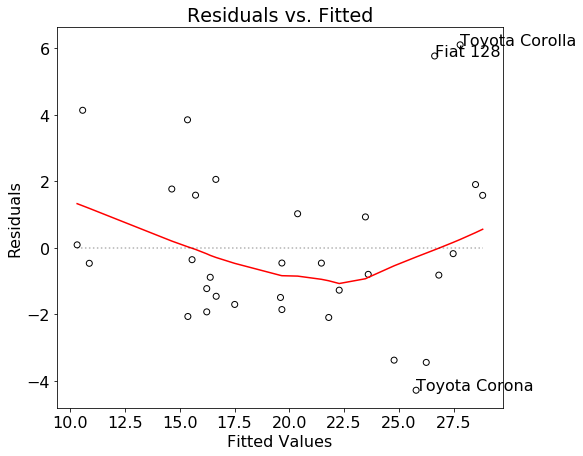

In [43]:
residuals = results.resid
fitted = results.fittedvalues
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams["figure.figsize"] = (8,7)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
ax.set_title('Residuals vs. Fitted')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.show()
#plt.savefig('ResidualsVFitted20191119.png', dpi = 300, bbox_inches = 'tight')

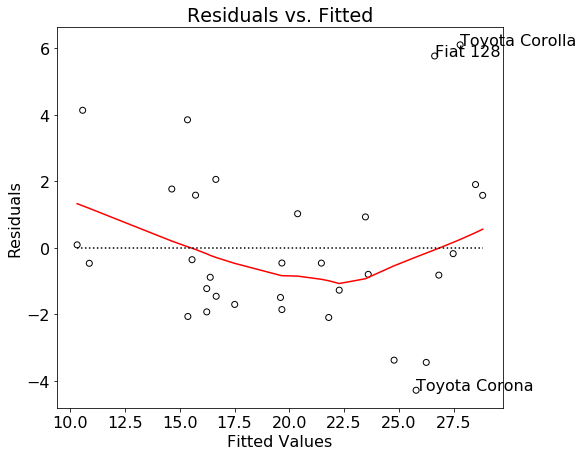

In [44]:
OLSplots.ResidFitted(fitted_model = 'none',residuals = residuals,fits = fitted)
plt.show()

## 2. Normal QQ Plot

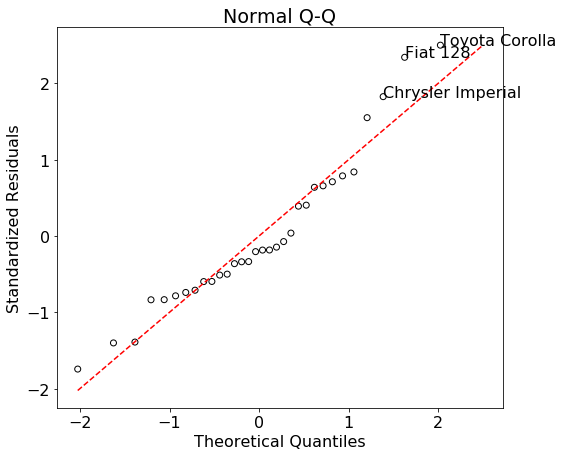

In [45]:
sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
sorted_student_residuals.index = results.resid.index
sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
df = pd.DataFrame(sorted_student_residuals)
df.columns = ['sorted_student_residuals']
df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
top3 = rankings[:3]

fig, ax = plt.subplots()
x = df['theoretical_quantiles']
y = df['sorted_student_residuals']
ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
ax.set_title('Normal Q-Q')
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Theoretical Quantiles')
ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
for val in top3.index:
    ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
plt.show()
#plt.savefig('NormalQQp20191119.png', dpi = 300, bbox_inches = 'tight')

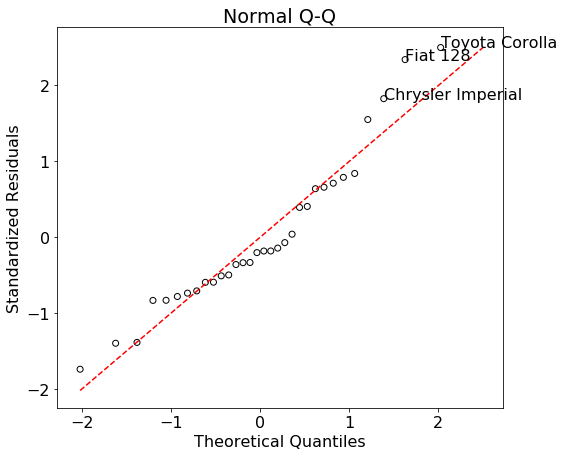

In [46]:
OLSplots.qqplot(results)
plt.show()

## 3. Scale - location plot

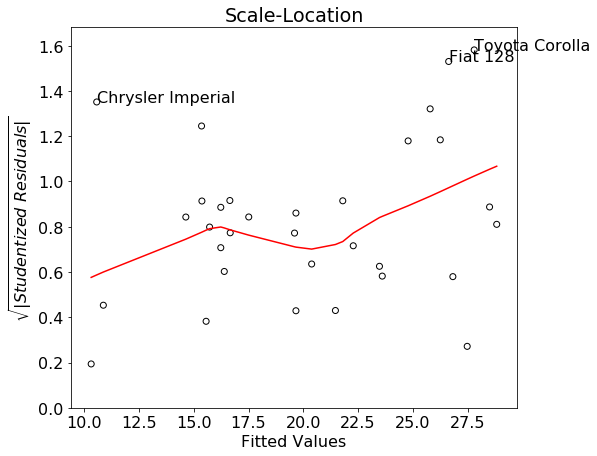

In [47]:
student_residuals = results.get_influence().resid_studentized_internal
sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
sqrt_student_residuals.index = results.resid.index
smoothed = lowess(sqrt_student_residuals,fitted)
top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

fig, ax = plt.subplots()
ax.scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
ax.set_xlabel('Fitted Values')
ax.set_title('Scale-Location')
ax.set_ylim(0,max(sqrt_student_residuals)+0.1)
for i in top3.index:
    ax.annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))
plt.show()
#plt.savefig('ScaleLocation20191119.png', dpi = 300, bbox_inches = 'tight')

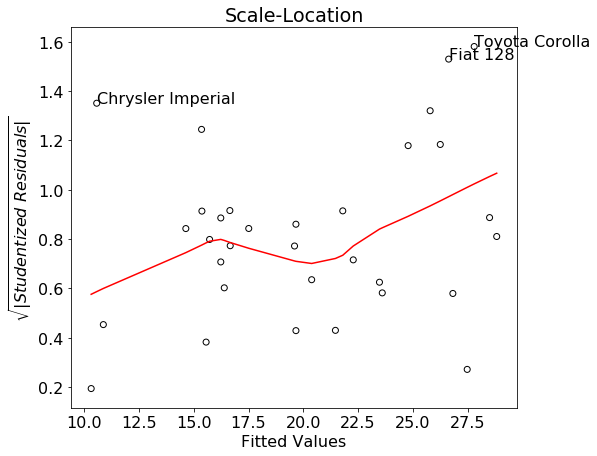

In [48]:
OLSplots.ScaleLocation(results)
plt.show()

## 4. Residuals vs. Leverage

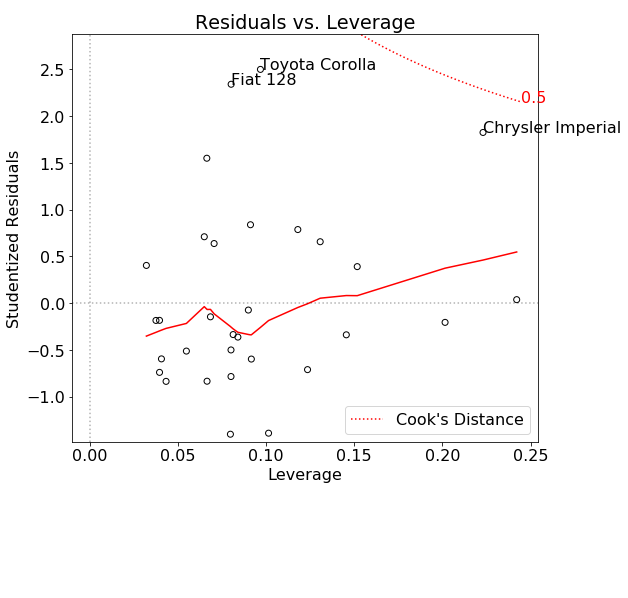

In [49]:
student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
student_residuals.index = results.resid.index
df = pd.DataFrame(student_residuals)
df.columns = ['student_residuals']
df['leverage'] = results.get_influence().hat_matrix_diag
smoothed = lowess(df['student_residuals'],df['leverage'])
sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
top3 = sorted_student_residuals[:3]

fig, ax = plt.subplots()
x = df['leverage']
y = df['student_residuals']
xpos = max(x)+max(x)*0.01  
ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Studentized Residuals')
ax.set_xlabel('Leverage')
ax.set_title('Residuals vs. Leverage')
ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
ax.set_xlim(-0.01,max(x)+max(x)*0.05)
plt.tight_layout()
for val in top3.index:
    ax.annotate(val,xy=(x.loc[val],y.loc[val]))

cooksx = np.linspace(min(x), xpos, 50)
p = len(results.params)
poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
ax.legend()
plt.show()
#plt.savefig('ResidualsVLeverage20191119.png', dpi = 300, bbox_inches = 'tight');

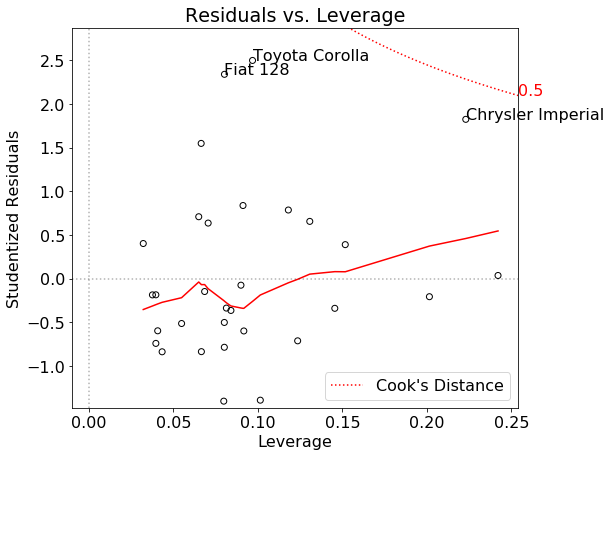

In [50]:
OLSplots.Leverage(results)
plt.show()